Executing R1 tasks:
   pick_and_place(red block, green block)
   pick_and_place(blue block, yellow block)
Executing R2 tasks:


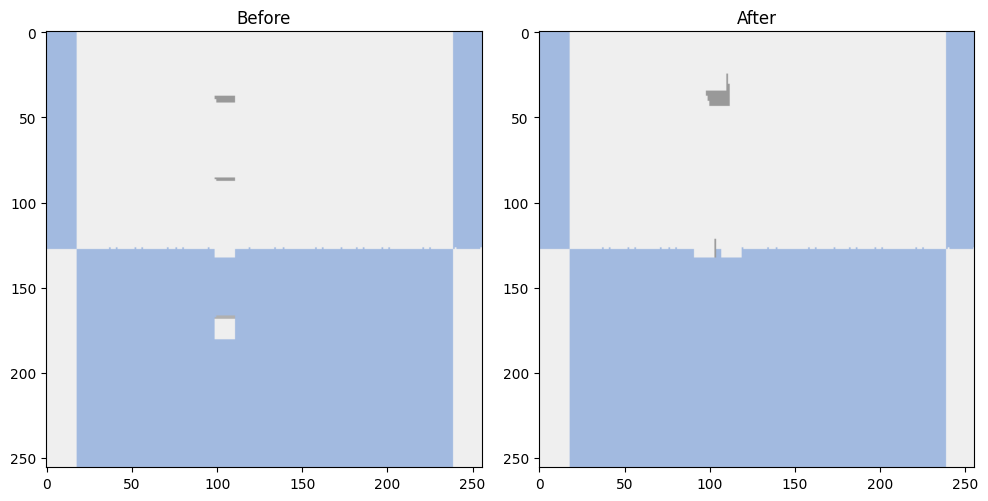

In [1]:
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
import time
import cv2

# ---------- ENVIRONMENT SETUP ---------- #
class DualRobotEnv:
    def __init__(self):
        self.client = p.connect(p.DIRECT)  # Use DIRECT for speed
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        self._load_scene()

    def _load_scene(self):
        p.loadURDF("plane.urdf")
        self.blocks = {}
        self.positions = {
            "red block": [0.4, -0.2, 0.05],
            "green block": [0.4, 0.0, 0.05],
            "blue block": [0.4, 0.2, 0.05],
            "yellow block": [0.4, 0.4, 0.05]
        }
        for name, pos in self.positions.items():
            self.blocks[name] = p.loadURDF("cube_small.urdf", pos)

    def execute(self, command):
        src, dst = command
        src_id = self.blocks[src]
        if dst in self.positions:
            dst_pos = self.positions[dst]
        else:
            dst_pos = [0.6, 0, 0.05]  # default center
        p.resetBasePositionAndOrientation(src_id, dst_pos, [0, 0, 0, 1])
        for _ in range(30): p.stepSimulation()

    def render_top(self):
        width, height = 256, 256
        view = p.computeViewMatrix(cameraEyePosition=[0.5, 0, 1],
                                   cameraTargetPosition=[0.5, 0, 0],
                                   cameraUpVector=[0, 1, 0])
        proj = p.computeProjectionMatrixFOV(60, 1, 0.1, 1.5)
        _, _, px, _, _ = p.getCameraImage(width, height, view, proj)
        img = np.reshape(px, (height, width, 4))[:, :, :3]
        return img

    def close(self):
        p.disconnect()

# ---------- TASK LOGIC ---------- #
def parse_instruction_to_tasks(instruction):
    # Manually convert to symbolic skill set
    return [
        ("red block", "green block"),
        ("blue block", "yellow block")
    ]

def build_task_graph(tasks):
    G = nx.DiGraph()
    for src, dst in tasks:
        task = f"pick_and_place({src}, {dst})"
        G.add_node(task)
    # Example: enforce serial stacking by adding dependencies
    if len(tasks) > 1:
        for i in range(len(tasks)-1):
            G.add_edge(f"pick_and_place({tasks[i][0]}, {tasks[i][1]})",
                       f"pick_and_place({tasks[i+1][0]}, {tasks[i+1][1]})")
    return G

def allocate_tasks(G):
    tasks = list(G.nodes)
    prob = LpProblem("DualArmAllocation", LpMinimize)
    x = {t: LpVariable(f"x_{t}", 0, 1, cat="Binary") for t in tasks}  # 0 for R1, 1 for R2

    for u, v in G.edges:
        prob += x[u] <= x[v]  # order preservation

    prob += lpSum([x[t] for t in tasks])  # dummy objective
    prob.solve()

    r1_tasks = [t for t in tasks if x[t].value() == 0.0]
    r2_tasks = [t for t in tasks if x[t].value() == 1.0]
    return r1_tasks, r2_tasks

def extract_command(task_str):
    return tuple(task_str.replace("pick_and_place(", "").replace(")", "").split(", "))

# ---------- PIPELINE ---------- #
def run_pipeline(instruction):
    tasks = parse_instruction_to_tasks(instruction)
    G = build_task_graph(tasks)
    r1_tasks, r2_tasks = allocate_tasks(G)

    env = DualRobotEnv()
    before = env.render_top()

    print("Executing R1 tasks:")
    for task in r1_tasks:
        print("  ", task)
        env.execute(extract_command(task))

    print("Executing R2 tasks:")
    for task in r2_tasks:
        print("  ", task)
        env.execute(extract_command(task))

    after = env.render_top()
    env.close()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(before)
    axs[0].set_title("Before")
    axs[1].imshow(after)
    axs[1].set_title("After")
    plt.tight_layout()
    plt.show()

# ---------- RUN THE SYSTEM ---------- #
run_pipeline("Stack red block on green and place blue block in yellow block")
